# <b> Certification Project to build Movie Recommender Systems:
<h3> This movie recommendation platform allows users to get movie recommendations based on movies they've seen, preferred genres, and movies liked by other users.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Importing necessary libraries:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#csr_matrix and NearestNeighbors algorithm:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [3]:
#Loading datasets:
movies_ds = pd.read_csv('movies.csv')
ratings_ds = pd.read_csv('ratings.csv')

In [4]:
# Shapes of two ds:
movies_ds.shape, ratings_ds.shape

((10329, 3), (105339, 4))

In [5]:
# Displaying first 5 records of movies dataset:
movies_ds.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
# Displaying first 5 records of ratings dataset:
ratings_ds.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


## EDA process:

#### Checking for any null values or duplicated:

In [7]:
movies_ds.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

In [8]:
ratings_ds.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [9]:
movies_ds.duplicated().sum()

0

In [10]:
ratings_ds.duplicated().sum()

0

<h5> <I> Hence, there are neither null values nor duplicated values in the two datasets.

In [11]:
movies_ds.count()

movieId    10329
title      10329
genres     10329
dtype: int64

In [12]:
movies_ds['movieId'].nunique()

10329

In [13]:
movies_ds['genres'].nunique()

938

In [14]:
movies_ds['title'].nunique()

10327

<I> Out of 10329, 10011 are unique movies(titles), 938 are unique genres(separate and mixed genres) of different movies

#### Distribution of different ratings value:

In [15]:
ratings_ds['rating'].value_counts()

4.0    28880
3.0    21729
5.0    14856
3.5    12237
4.5     8187
2.0     7943
2.5     5484
1.0     3258
1.5     1567
0.5     1198
Name: rating, dtype: int64

#### By this we can determine that the average rating is 3.5 given to a movie by no.of users
#### Also, there are max 149532 movies rated by 668 users

In [16]:
ratings_ds.describe()

,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


In [17]:
## Removing movie year information such as 'Batman (1989)' to "Batman":
movies_ds_copy = movies_ds[:] #keeping copy of the original dataset
movies_ds['title'] = movies_ds['title'].str.replace(r'\s*\(\d+\)', '')
movies_ds['title'].head(10)

0                      Toy Story
1                        Jumanji
2               Grumpier Old Men
3              Waiting to Exhale
4    Father of the Bride Part II
5                           Heat
6                        Sabrina
7                   Tom and Huck
8                   Sudden Death
9                      GoldenEye
Name: title, dtype: object

### Merging the two datasets to have one dataset as a whole:

In [18]:
merged_df = movies_ds.merge(ratings_ds, on='movieId')
merged_df.head(10)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2,5.0,859046895
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1303501039
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,8,5.0,858610933
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,11,4.0,850815810
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,14,4.0,851766286
5,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,5.0,1350206819
6,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,28,3.0,884098350
7,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,29,4.0,846942580
8,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,30,4.5,1292690069
9,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,31,4.0,832397496


In [19]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105339 entries, 0 to 105338
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    105339 non-null  int64  
 1   title      105339 non-null  object 
 2   genres     105339 non-null  object 
 3   userId     105339 non-null  int64  
 4   rating     105339 non-null  float64
 5   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.6+ MB


### Creating movie matrix:

In [20]:
movie_mat = merged_df.pivot_table(index='userId', columns='title', values='rating')
movie_mat.head(5)

title,Days of Summer,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Til There Was You,"'burbs, The",'night Mother,*batteries not included,...And Justice for All,10,...,[REC],[REC]²,[REC]³ 3 Génesis,a/k/a Tommy Chong,eXistenZ,loudQUIETloud: A Film About the Pixies,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
movie_mat.tail()

title,Days of Summer,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Til There Was You,"'burbs, The",'night Mother,*batteries not included,...And Justice for All,10,...,[REC],[REC]²,[REC]³ 3 Génesis,a/k/a Tommy Chong,eXistenZ,loudQUIETloud: A Film About the Pixies,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté (Freedom for Us)
userId,,,,,,,,,,,,,,,,,,,,,
664,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
666,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN
667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,2.0,NaN,NaN,2.5,NaN,NaN,NaN,NaN,3.0,2.5,...,NaN,1.5,0.5,NaN,2.0,NaN,3.5,NaN,2.0,3.0


saving it to excel file for reference purpose:
excel = movie_mat.to_excel('movie_matrix.xlsx')Corr_batman1989

## <span style='color:Red'> Content-based Collaborative Recommendaton System:

In [22]:
# Displaying movies in genre "Action|Comedy|Sci-Fi" :
movies_ds[movies_ds['genres']=='Action|Comedy|Sci-Fi'].head(10) #.count()

,movieId,title,genres
287,327,Tank Girl,Action|Comedy|Sci-Fi
1130,1391,Mars Attacks!,Action|Comedy|Sci-Fi
1260,1580,Men in Black (a.k.a. MIB),Action|Comedy|Sci-Fi
2171,2716,Ghostbusters (a.k.a. Ghost Busters),Action|Comedy|Sci-Fi
4183,5459,Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2),Action|Comedy|Sci-Fi
6785,39052,Star Wreck: In the Pirkinning,Action|Comedy|Sci-Fi
7690,59014,Superhero Movie,Action|Comedy|Sci-Fi
9009,87192,Attack the Block,Action|Comedy|Sci-Fi
9317,93805,Iron Sky,Action|Comedy|Sci-Fi
9713,103341,"World's End, The",Action|Comedy|Sci-Fi


### Please execute the below cell once again and then put movie name from the above movie list to get the recommendations:

In [48]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Creating input widgets for movie name and number of recommendations
movie_title_widget = widgets.Text(
    value='',
    placeholder='Enter your interested movie name',
    description='Movie Name:',
    disabled=False
)

num_recomms_widget = widgets.IntText(
    value=5,
    description='Num Recommends:',
    disabled=False
)

output = widgets.Output()

# Define a function to generate recommendations
def generate_recommendations(movie_title, num_recomms):
    Filtered_dataset = movie_mat[movie_title] #selection of movie
    similar_to_movie_title = movie_mat.corrwith(Filtered_dataset) #applying Pearson Correlation
    Corr_movie_title = pd.DataFrame(similar_to_movie_title, columns=['Correlation']) #correlation df
    Corr_movie_title.dropna(inplace=True) #dropping null values
    Corr_movie_title = Corr_movie_title.sort_values('Correlation', ascending=False) #sorting according to correlation

    movie_title_ratings = pd.DataFrame(merged_df.groupby('title')['rating'].mean()) #ratings mean df
    movie_title_ratings['No_of_ratings'] = pd.DataFrame(merged_df.groupby('title')['rating'].count()) #count df
    movie_title_ratings.drop('rating', axis=1, inplace=True) #dropping null values again
    Corr_movie_title = Corr_movie_title.join(movie_title_ratings['No_of_ratings']) #joining No. of ratings cols
    
    #Threshold of 100 ratings for a selected movie
    Recommendations = Corr_movie_title[Corr_movie_title['No_of_ratings'] > 100].sort_values('Correlation', ascending=False)
    return Recommendations.head(num_recomms) #requested number of recommendations

# Create a button widget to trigger recommendations
generate_button = widgets.Button(
    description='Generate Recommendations',
    disabled=False,
    button_style='success',  # 'success', 'info', 'warning', 'danger' or ''
)

# Define a function to handle button click event
def generate_button_click(b):
    output.clear_output()
    movie_name = movie_title_widget.value
    num_recommendations = num_recomms_widget.value
    with output:
        recommendations = generate_recommendations(movie_name, num_recommendations)
        display(recommendations)

generate_button.on_click(generate_button_click)

# Display the widgets
display(movie_title_widget)
display(num_recomms_widget)
display(generate_button)
print("Next Movie Recommendations ======>")
display(output)

Text(value='', description='Movie Name:', placeholder='Enter your interested movie name')

IntText(value=5, description='Num Recommends:')

Button(button_style='success', description='Generate Recommendations', style=ButtonStyle())

Next Movie Recommendations ======>


Output()

#movies_ds[movies_ds['title']=='Spider-Man']
    #movies_ds[movies_ds['title']=='Men in Black II (a.k.a. MIIB) (a.k.a. MIB 2)']
    #movies_ds[movies_ds['title']=='Toy Story 2']
    #movies_ds[movies_ds['title']=='Aladdin']
    #movies_ds[movies_ds['title']=='Mask, The']
#movies_ds[movies_ds['title']=='Dark Knight, The']    

## <span style='color:Red'> Popularity-Based Colloborative Recommendation System:

In [24]:
# Viewing different genres present in the dataset:
genres = list(movies_ds['genres'].unique())
print(genres[:30])

['Adventure|Animation|Children|Comedy|Fantasy', 'Adventure|Children|Fantasy', 'Comedy|Romance', 'Comedy|Drama|Romance', 'Comedy', 'Action|Crime|Thriller', 'Adventure|Children', 'Action', 'Action|Adventure|Thriller', 'Comedy|Horror', 'Adventure|Animation|Children', 'Drama', 'Action|Adventure|Romance', 'Crime|Drama', 'Drama|Romance', 'Action|Comedy|Crime|Drama|Thriller', 'Comedy|Crime|Thriller', 'Crime|Drama|Horror|Mystery|Thriller', 'Drama|Sci-Fi', 'Children|Drama', 'Adventure|Drama|Fantasy|Mystery|Sci-Fi', 'Mystery|Sci-Fi|Thriller', 'Adventure|Romance|IMAX', 'Drama|War', 'Action|Crime|Drama', 'Action|Adventure|Fantasy', 'Comedy|Drama|Thriller', 'Mystery|Thriller', 'Animation|Children|Drama|Musical|Romance', 'Crime|Mystery|Thriller']


In [25]:
movies_ds.nunique()

movieId    10329
title      10011
genres       938
dtype: int64

Checking for selected genre's movies before-hand:

Genre_input = input('Enter your genre:').strip() #strip to remove any leading and trailing whitespaces

#Viewing or displaying inputted genre type of movies:
movies_ds[movies_ds['genres'].str.contains(Genre_input)].head(10)

### Merging two dfs using left join method:

In [26]:
merged_df1 = pd.merge(ratings_ds, movies_ds, on='movieId', how='left')
merged_df1.head(2)

,userId,movieId,rating,timestamp,title,genres
0,1,16,4.0,1217897793,Casino,Crime|Drama
1,1,24,1.5,1217895807,Powder,Drama|Sci-Fi


In [27]:
merged_df1.shape

(105339, 6)

In [28]:
merged_df1_copy = merged_df1[:]
merged_df1 = merged_df1[['title', 'genres','rating']] #taking only requied columns
merged_df1.head(2)

,title,genres,rating
0,Casino,Crime|Drama,4.0
1,Powder,Drama|Sci-Fi,1.5


### Here, also execute the below cell once again to get the recommendations:

In [49]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import display

# Creating input widgets for genre, minimum reviews, and number of recommendations
genre_widget = widgets.Text(
    value='',
    placeholder='Enter your favorite genre',
    description='Genre:',
    disabled=False
)

mini_thresh_widget = widgets.IntText(
    value=100,
    description='Min Reviews:',
    disabled=False
)

num_recommends_widget = widgets.IntText(
    value=5,
    description='Num of Recommends:',
    disabled=False
)

# Define a function to generate genre-wise recommendations
def generate_genre_recommendations(genre, mini_thresh, num_recommends): #keeping genres column to make out all movies present in
    moviedf = merged_df1.groupby(['title', 'genres']).agg({'rating': ['mean', 'count']}) #selected genre
    moviedf.columns = ['Avg Rating', 'Num Reviews'] #renaming column names
    moviedf = moviedf.reset_index() #reseting index to again create columns from indexes
    moviedf = moviedf.sort_values('Num Reviews', ascending=False) #sorting according to Num Reviews
    
    selection_genre = moviedf[moviedf['genres'].str.contains(genre)] #validation to contain the genre type
    minimum_ratings = selection_genre[selection_genre['Num Reviews'] > mini_thresh] #filtering according to minimum threshold
    return minimum_ratings.head(num_recommends) #displaying according to requested number of recommendations

# Creating a button widget to trigger recommendations
generate_button = widgets.Button(
    description='Generate Recommendations',
    disabled=False,
    button_style='success'  # 'success', 'info', 'warning', 'danger' or ''
)

output = widgets.Output() #to return output

# Defining a function to handle button click event
def generate_button_click(b):
    output.clear_output() #clearing output
    genre = genre_widget.value.strip() #strip to remove leading and trailing spaces
    mini_thresh = mini_thresh_widget.value
    num_recommends = num_recommends_widget.value
    with output:
        recommendations = generate_genre_recommendations(genre, mini_thresh, num_recommends) #1st function calling
        display(recommendations)

generate_button.on_click(generate_button_click) #2nd function calling

# Display the widgets
display(genre_widget)
display(mini_thresh_widget)
display(num_recommends_widget)
display(generate_button)
print("Your watch list for the selected genre ======>")
display(output)

Text(value='', description='Genre:', placeholder='Enter your favorite genre')

IntText(value=100, description='Min Reviews:')

IntText(value=5, description='Num of Recommends:')

Button(button_style='success', description='Generate Recommendations', style=ButtonStyle())

Your watch list for the selected genre ======>


Output()

## <span style='color:Red'> User_based Colloborative Recommendation System using KNN algorithm:

In [30]:
merged_df.head(2)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2,5.0,859046895
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1303501039


In [31]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105339 entries, 0 to 105338
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    105339 non-null  int64  
 1   title      105339 non-null  object 
 2   genres     105339 non-null  object 
 3   userId     105339 non-null  int64  
 4   rating     105339 non-null  float64
 5   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.6+ MB


In [32]:
# Creating movie matrix for colloborative filtering recommendation system:
movies_matrics = merged_df.pivot_table(index='movieId', columns='userId', values='rating')
movies_matrics.fillna(0, inplace=True)
movies_matrics.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,5.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,4.0,5.0,3.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5


In [33]:
#userId = 1 ratings distribution:
movies_matrics[1].value_counts()

0.0    10212
4.0       26
4.5       25
3.5       21
3.0       12
5.0       12
1.5        6
0.5        6
2.5        4
2.0        1
Name: 1, dtype: int64

In [34]:
movies_matrics.shape

(10325, 668)

<B> 1. To qualify a movie, a minimum of 10 users should have voted a movie. 
<br><B> 2. To qualify a user, a minimum of 50 movies should have voted by the user.

In [35]:
no_user_voted = ratings_ds.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings_ds.groupby('userId')['rating'].agg('count')

In [36]:
no_user_voted.shape, no_movies_voted.shape

((10325,), (668,))

### Visualization of constraints decided:

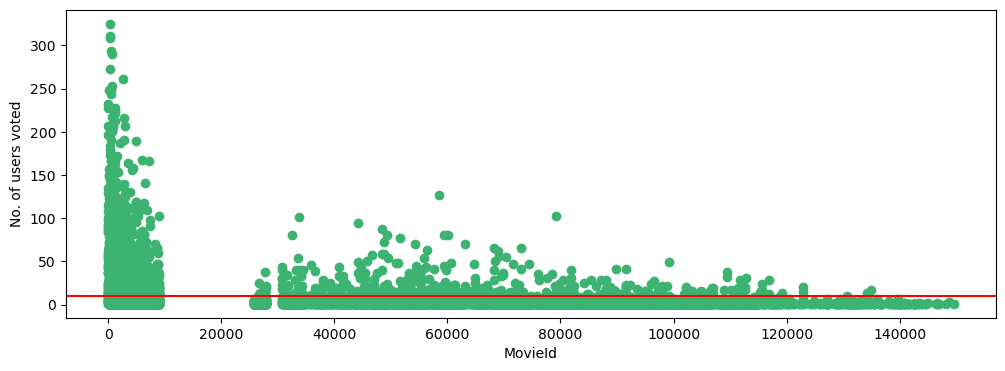

In [37]:
f,ax = plt.subplots(1,1,figsize=(12,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(no_user_voted.index,no_user_voted,color='mediumseagreen')
plt.axhline(y=10,color='r') #threshold of 10 users ratings
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.show()

In [38]:
final_dataset = movies_matrics.loc[no_user_voted[no_user_voted > 10].index,:] #selecting only those movies which are voted by more than 10 users
final_dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,5.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,4.0,5.0,3.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5


In [39]:
final_dataset.shape
#movies count reduced to 2160 because of the 1st constraint applied

(2160, 668)

### Visualizing the number of votes by each user with the threshold value of 50.

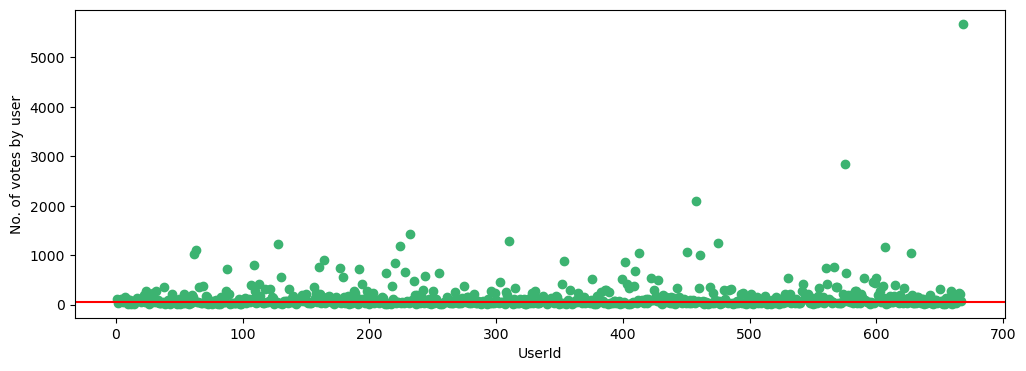

In [40]:
f,ax = plt.subplots(1,1,figsize=(12,4))
plt.scatter(no_movies_voted.index,no_movies_voted,color='mediumseagreen')
plt.axhline(y=50,color='r') #threshold of votes by each user in terms of all movies available
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.show()

#### Now, applying the second constraint, the columns size will also get reduced:

In [41]:
final_dataset=final_dataset.loc[:,no_movies_voted[no_movies_voted > 50].index] #selecting only those users who had voted more than 50 movies
final_dataset.head()

userId,1,3,4,5,6,7,8,9,11,15,...,656,657,659,661,662,664,665,666,667,668
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,...,0.0,0.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,3.0
3,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,3.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,2.5


In [42]:
final_dataset.shape
#Columns reduced to 420 from 668

(2160, 420)

In [43]:
# For using csr_matrix and NearestNeighbors algorithm:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [44]:
# Applying csr_matrix function to remove sparsity from the dataset:
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)

final_dataset.head()

#Displaying first record of csr_data
print(csr_data.toarray()[:1])

In [45]:
final_dataset.shape

(2160, 421)

### Here, we are going to use cosine distance metric to get similarity between different data points(users):

In [46]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1) #intializing the model
knn.fit(csr_data) #fitting the csr_data with the model

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [50]:
import ipywidgets as widgets
from IPython.display import display

# Create an input widget for movie name
movie_name_widget = widgets.Text(
    value='',
    placeholder='Enter a movie name',
    description='Movie Name:',
    disabled=False
)

output = widgets.Output()

# Define a function to get movie recommendations
def get_movie_recommendation(movie_name):
    n_movies_to_recommend = 10
    movie_list = merged_df[merged_df['title'].str.contains(movie_name)]
    
    if len(movie_list) > 0:
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]
        
        distances, indices = knn.kneighbors(csr_data[movie_idx], n_neighbors=n_movies_to_recommend + 1)
        rec_movie_indices = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())),
                                    key=lambda x: x[1])[:0:-1]
        
        recommend_frame = []
        
        for val in rec_movie_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = merged_df[merged_df['movieId'] == movie_idx].index
            recommend_frame.append({'Title': merged_df.iloc[idx]['title'].values[0], 'Distance': val[1]})
        
        df = pd.DataFrame(recommend_frame, index=range(1, n_movies_to_recommend + 1))
        return df
    else:
        return "No movies found. Please check your input"

# Define a function to handle button click event
def get_recommendations_button_click(b):
    output.clear_output()
    movie_name = movie_name_widget.value
    with output:
        recommendations = get_movie_recommendation(movie_name)
        display(recommendations)

# Create a button widget to trigger recommendations
get_recommendations_button = widgets.Button(
    description='Get Recommendations',
    disabled=False,
    button_style='success'  # 'success', 'info', 'warning', 'danger' or ''
)

# Set the button's click event handler
get_recommendations_button.on_click(get_recommendations_button_click)

# Display the widgets
display(movie_name_widget)
display(get_recommendations_button)
print("Top 10 Movies related to this movie ===>")
display(output)

Text(value='', description='Movie Name:', placeholder='Enter a movie name')

Button(button_style='success', description='Get Recommendations', style=ButtonStyle())

Top 10 Movies related to this movie ===>


Output()

#Test1:
get_movie_recommendation('Liar Liar')

#Test2:
get_movie_recommendation('Spider-Man')

movies_ds[movies_ds['title']=='Iron Man']

### While working on this project, I built three types of recommendation systems and gone through the EDA process. I also added ipywidgets to make the generation of results more visually appealing.